In [55]:
import torch
from torch import nn
import pandas as pd
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [56]:
RANDOM_SEED = 42
BATCH_SIZE=512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4 # 4x4 patches to cut from a 28x28 image
IMG_SIZE = 28
IN_CHANNELS = 1 # IMAGE CHANNELS 1 since BW
NUM_HEADS = 4 #attention heads
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9,0.999)
ACTIVATION = 'gelu'
NUM_ENCODERS = 8
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16 in this case
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False


device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [57]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches,dropout,in_channels) -> None:
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size
                    ),
                    nn.Flatten(2))
        self.cls_token = nn.Parameter(torch.randn(size=(1,in_channels,embed_dim),requires_grad=True))
        self.position_embeddings = nn.Parameter(torch.randn(size=(1,num_patches+1,embed_dim)),requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self,x):
        cls_token = self.cls_token.expand(x.shape[0],-1,-1) # copy the same class token as many as batch size
        x = self.patcher(x).permute(0,2,1) # Patcher convolutes and patches the image into 4x4 sections
        x= torch.cat([cls_token,x],dim=1) # adds class token to all patch embeddings
        x = self.position_embeddings + x
        x=self.dropout(x) # dropout for training
        return x



In [58]:
class ViT(nn.Module):
    def __init__(self, num_patches, num_classes, patch_size,embed_dim, num_encoders,num_heads,hidden_dim, dropout,activation, in_channels) -> None:
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size,num_patches,dropout,in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim,nhead=num_heads,dropout=dropout,activation=activation,batch_first=True,norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer,num_layers=num_encoders)
        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim,out_features=embed_dim)
        )

    def forward(self,x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:,0,:])
        return x

model = ViT(NUM_PATCHES,NUM_CLASSES,PATCH_SIZE,EMBED_DIM,NUM_ENCODERS,NUM_HEADS,HIDDEN_DIM,DROPOUT,ACTIVATION,IN_CHANNELS).to(device)
x = torch.randn(512,1,28,28).to(device)
print(model(x).shape)

torch.Size([512, 16])


s:\Data\Software\Anaconda\envs\vit\Lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [59]:
train_df=pd.read_csv("./Data/digit-recognizer/train.csv")
test_df=pd.read_csv("./Data/digit-recognizer/test.csv")
submission_df=pd.read_csv("./Data/digit-recognizer/sample_submission.csv")

In [60]:
train_df.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [61]:
test_df.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [62]:
submission_df.head()

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0


In [63]:
train_df, val_df = train_test_split(train_df,test_size=0.1,random_state=RANDOM_SEED,shuffle=True)

In [64]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indices) -> None:
        self.images=images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([transforms.ToPILImage(),
                                             transforms.RandomRotation(15),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.5],[0.5])])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)

        return {'image':image,'label':label,'index':index}



class MNISTVALDataset(Dataset):
    def __init__(self, images, labels, indices) -> None:
        self.images=images
        self.labels = labels
        self.indices = indices
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize([0.5],[0.5])])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indices[idx]
        image = self.transform(image)

        return {'image':image,'label':label,'index':index}


class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indices) -> None:
        self.images=images
        self.indices = indices
        self.transform = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize([0.5],[0.5])])
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape((28,28)).astype(np.uint8)
        index = self.indices[idx]
        image = self.transform(image)

        return {'image':image,'index':index}
        

37800
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<Figure size 640x480 with 0 Axes>

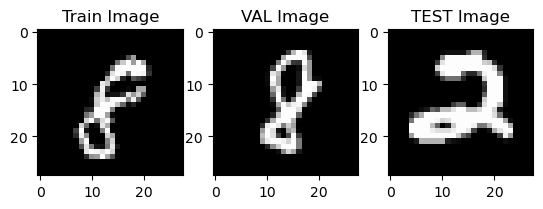

In [65]:
plt.figure()
f, axarr = plt.subplots(1,3)
train_dataset = MNISTTrainDataset(train_df.iloc[:,1:].values.astype(np.uint8),train_df.iloc[:,0].values,train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]['image'].squeeze(),cmap='gray')
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTVALDataset(val_df.iloc[:,1:].values.astype(np.uint8),val_df.iloc[:,0].values,val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]['image'].squeeze(),cmap='gray')
axarr[1].set_title("VAL Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8),test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]['image'].squeeze(),cmap='gray')
axarr[2].set_title("TEST Image")
print("-"*30)

plt.show()

In [66]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,shuffle=False)

In [67]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),betas=ADAM_BETAS,lr=LEARNING_RATE,weight_decay=ADAM_WEIGHT_DECAY)
start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS),position=0,leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss =0
    for idx,img_label in enumerate(tqdm(train_dataloader,position=0,leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred,dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred,label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    
    train_loss = train_running_loss/(idx+1)

    model.eval()
    val_labels =[]
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, image_label in enumerate(tqdm(val_dataloader,position=0,leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)

            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred,dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred,label)

            val_running_loss +=loss.item()
    
    val_loss = val_running_loss /(idx+1)

    print("-"*30)
    print(f"Train loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Validation loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {(sum(1 for x,y in zip(train_preds,train_labels) if x==y) /len(train_labels)):.4f}")
    print(f"Validation Accuracy EPOCH {epoch+1}: {(sum(1 for x,y in zip(val_preds,val_labels) if x==y) /len(val_labels)):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")



  2%|▎         | 1/40 [00:10<07:01, 10.81s/it]

------------------------------
Train loss EPOCH 1: 2.5315
Validation loss EPOCH 1: 2.4736
Train Accuracy EPOCH 1: 0.0969
Validation Accuracy EPOCH 1: 0.1108
------------------------------


  5%|▌         | 2/40 [00:19<06:12,  9.80s/it]

------------------------------
Train loss EPOCH 2: 2.2875
Validation loss EPOCH 2: 2.0478
Train Accuracy EPOCH 2: 0.2536
Validation Accuracy EPOCH 2: 0.4151
------------------------------


  8%|▊         | 3/40 [00:30<06:14, 10.13s/it]

------------------------------
Train loss EPOCH 3: 1.9337
Validation loss EPOCH 3: 1.8644
Train Accuracy EPOCH 3: 0.4494
Validation Accuracy EPOCH 3: 0.4575
------------------------------


 10%|█         | 4/40 [00:41<06:13, 10.37s/it]

------------------------------
Train loss EPOCH 4: 1.7177
Validation loss EPOCH 4: 1.5803
Train Accuracy EPOCH 4: 0.5392
Validation Accuracy EPOCH 4: 0.6014
------------------------------


 12%|█▎        | 5/40 [00:51<05:56, 10.19s/it]

------------------------------
Train loss EPOCH 5: 1.5310
Validation loss EPOCH 5: 1.4191
Train Accuracy EPOCH 5: 0.6159
Validation Accuracy EPOCH 5: 0.6604
------------------------------


 15%|█▌        | 6/40 [01:01<05:52, 10.36s/it]

------------------------------
Train loss EPOCH 6: 1.3807
Validation loss EPOCH 6: 1.2641
Train Accuracy EPOCH 6: 0.6745
Validation Accuracy EPOCH 6: 0.6958
------------------------------


 18%|█▊        | 7/40 [01:12<05:44, 10.43s/it]

------------------------------
Train loss EPOCH 7: 1.2495
Validation loss EPOCH 7: 1.1620
Train Accuracy EPOCH 7: 0.7234
Validation Accuracy EPOCH 7: 0.7429
------------------------------


 20%|██        | 8/40 [01:22<05:35, 10.50s/it]

------------------------------
Train loss EPOCH 8: 1.1459
Validation loss EPOCH 8: 1.0532
Train Accuracy EPOCH 8: 0.7511
Validation Accuracy EPOCH 8: 0.7689
------------------------------


 22%|██▎       | 9/40 [01:33<05:27, 10.56s/it]

------------------------------
Train loss EPOCH 9: 1.0519
Validation loss EPOCH 9: 0.9931
Train Accuracy EPOCH 9: 0.7790
Validation Accuracy EPOCH 9: 0.8042
------------------------------


 25%|██▌       | 10/40 [01:44<05:17, 10.57s/it]

------------------------------
Train loss EPOCH 10: 0.9685
Validation loss EPOCH 10: 0.9614
Train Accuracy EPOCH 10: 0.7971
Validation Accuracy EPOCH 10: 0.7995
------------------------------


 28%|██▊       | 11/40 [01:54<05:07, 10.60s/it]

------------------------------
Train loss EPOCH 11: 0.8973
Validation loss EPOCH 11: 0.8357
Train Accuracy EPOCH 11: 0.8157
Validation Accuracy EPOCH 11: 0.8278
------------------------------


 30%|███       | 12/40 [02:05<04:55, 10.55s/it]

------------------------------
Train loss EPOCH 12: 0.8419
Validation loss EPOCH 12: 0.6778
Train Accuracy EPOCH 12: 0.8237
Validation Accuracy EPOCH 12: 0.8797
------------------------------


 32%|███▎      | 13/40 [02:16<04:46, 10.60s/it]

------------------------------
Train loss EPOCH 13: 0.7733
Validation loss EPOCH 13: 0.6664
Train Accuracy EPOCH 13: 0.8413
Validation Accuracy EPOCH 13: 0.8703
------------------------------


 35%|███▌      | 14/40 [02:26<04:35, 10.61s/it]

------------------------------
Train loss EPOCH 14: 0.7277
Validation loss EPOCH 14: 0.5990
Train Accuracy EPOCH 14: 0.8468
Validation Accuracy EPOCH 14: 0.8892
------------------------------


 38%|███▊      | 15/40 [02:37<04:26, 10.65s/it]

------------------------------
Train loss EPOCH 15: 0.6946
Validation loss EPOCH 15: 0.6146
Train Accuracy EPOCH 15: 0.8483
Validation Accuracy EPOCH 15: 0.8915
------------------------------


 40%|████      | 16/40 [02:48<04:15, 10.67s/it]

------------------------------
Train loss EPOCH 16: 0.6456
Validation loss EPOCH 16: 0.5283
Train Accuracy EPOCH 16: 0.8615
Validation Accuracy EPOCH 16: 0.9080
------------------------------


 42%|████▎     | 17/40 [02:57<03:58, 10.39s/it]

------------------------------
Train loss EPOCH 17: 0.6068
Validation loss EPOCH 17: 0.6153
Train Accuracy EPOCH 17: 0.8673
Validation Accuracy EPOCH 17: 0.8703
------------------------------


 45%|████▌     | 18/40 [03:08<03:50, 10.46s/it]

------------------------------
Train loss EPOCH 18: 0.5798
Validation loss EPOCH 18: 0.5379
Train Accuracy EPOCH 18: 0.8712
Validation Accuracy EPOCH 18: 0.8868
------------------------------


 48%|████▊     | 19/40 [03:17<03:31, 10.06s/it]

------------------------------
Train loss EPOCH 19: 0.5428
Validation loss EPOCH 19: 0.5287
Train Accuracy EPOCH 19: 0.8798
Validation Accuracy EPOCH 19: 0.8939
------------------------------


 50%|█████     | 20/40 [03:28<03:25, 10.25s/it]

------------------------------
Train loss EPOCH 20: 0.5136
Validation loss EPOCH 20: 0.4634
Train Accuracy EPOCH 20: 0.8839
Validation Accuracy EPOCH 20: 0.9151
------------------------------


 52%|█████▎    | 21/40 [03:39<03:17, 10.39s/it]

------------------------------
Train loss EPOCH 21: 0.4932
Validation loss EPOCH 21: 0.5127
Train Accuracy EPOCH 21: 0.8863
Validation Accuracy EPOCH 21: 0.8703
------------------------------


 55%|█████▌    | 22/40 [03:49<03:07, 10.41s/it]

------------------------------
Train loss EPOCH 22: 0.4617
Validation loss EPOCH 22: 0.4109
Train Accuracy EPOCH 22: 0.8941
Validation Accuracy EPOCH 22: 0.9057
------------------------------


 57%|█████▊    | 23/40 [03:59<02:54, 10.25s/it]

------------------------------
Train loss EPOCH 23: 0.4568
Validation loss EPOCH 23: 0.4168
Train Accuracy EPOCH 23: 0.8917
Validation Accuracy EPOCH 23: 0.9127
------------------------------


 60%|██████    | 24/40 [04:10<02:46, 10.38s/it]

------------------------------
Train loss EPOCH 24: 0.4274
Validation loss EPOCH 24: 0.3821
Train Accuracy EPOCH 24: 0.8980
Validation Accuracy EPOCH 24: 0.9175
------------------------------


 62%|██████▎   | 25/40 [04:20<02:35, 10.39s/it]

------------------------------
Train loss EPOCH 25: 0.4181
Validation loss EPOCH 25: 0.3632
Train Accuracy EPOCH 25: 0.9001
Validation Accuracy EPOCH 25: 0.9269
------------------------------


 65%|██████▌   | 26/40 [04:31<02:26, 10.44s/it]

------------------------------
Train loss EPOCH 26: 0.3942
Validation loss EPOCH 26: 0.3054
Train Accuracy EPOCH 26: 0.9040
Validation Accuracy EPOCH 26: 0.9340
------------------------------


 68%|██████▊   | 27/40 [04:41<02:16, 10.50s/it]

------------------------------
Train loss EPOCH 27: 0.3911
Validation loss EPOCH 27: 0.3417
Train Accuracy EPOCH 27: 0.9030
Validation Accuracy EPOCH 27: 0.9245
------------------------------


 70%|███████   | 28/40 [04:51<02:05, 10.45s/it]

------------------------------
Train loss EPOCH 28: 0.3736
Validation loss EPOCH 28: 0.3304
Train Accuracy EPOCH 28: 0.9067
Validation Accuracy EPOCH 28: 0.9080
------------------------------


 72%|███████▎  | 29/40 [05:02<01:55, 10.50s/it]

------------------------------
Train loss EPOCH 29: 0.3522
Validation loss EPOCH 29: 0.3012
Train Accuracy EPOCH 29: 0.9117
Validation Accuracy EPOCH 29: 0.9198
------------------------------


 75%|███████▌  | 30/40 [05:13<01:45, 10.56s/it]

------------------------------
Train loss EPOCH 30: 0.3592
Validation loss EPOCH 30: 0.3266
Train Accuracy EPOCH 30: 0.9081
Validation Accuracy EPOCH 30: 0.9269
------------------------------


 78%|███████▊  | 31/40 [05:24<01:35, 10.61s/it]

------------------------------
Train loss EPOCH 31: 0.3388
Validation loss EPOCH 31: 0.3072
Train Accuracy EPOCH 31: 0.9136
Validation Accuracy EPOCH 31: 0.9151
------------------------------


 80%|████████  | 32/40 [05:34<01:24, 10.59s/it]

------------------------------
Train loss EPOCH 32: 0.3268
Validation loss EPOCH 32: 0.2213
Train Accuracy EPOCH 32: 0.9151
Validation Accuracy EPOCH 32: 0.9458
------------------------------


 82%|████████▎ | 33/40 [05:45<01:14, 10.63s/it]

------------------------------
Train loss EPOCH 33: 0.3254
Validation loss EPOCH 33: 0.3074
Train Accuracy EPOCH 33: 0.9152
Validation Accuracy EPOCH 33: 0.9245
------------------------------


 85%|████████▌ | 34/40 [05:55<01:03, 10.62s/it]

------------------------------
Train loss EPOCH 34: 0.3090
Validation loss EPOCH 34: 0.2586
Train Accuracy EPOCH 34: 0.9193
Validation Accuracy EPOCH 34: 0.9363
------------------------------


 88%|████████▊ | 35/40 [06:06<00:53, 10.64s/it]

------------------------------
Train loss EPOCH 35: 0.2983
Validation loss EPOCH 35: 0.2350
Train Accuracy EPOCH 35: 0.9219
Validation Accuracy EPOCH 35: 0.9575
------------------------------


 90%|█████████ | 36/40 [06:17<00:42, 10.68s/it]

------------------------------
Train loss EPOCH 36: 0.2936
Validation loss EPOCH 36: 0.2973
Train Accuracy EPOCH 36: 0.9223
Validation Accuracy EPOCH 36: 0.9269
------------------------------


 92%|█████████▎| 37/40 [06:27<00:31, 10.66s/it]

------------------------------
Train loss EPOCH 37: 0.2903
Validation loss EPOCH 37: 0.3059
Train Accuracy EPOCH 37: 0.9206
Validation Accuracy EPOCH 37: 0.9057
------------------------------


 95%|█████████▌| 38/40 [06:38<00:21, 10.66s/it]

------------------------------
Train loss EPOCH 38: 0.2882
Validation loss EPOCH 38: 0.2821
Train Accuracy EPOCH 38: 0.9222
Validation Accuracy EPOCH 38: 0.9340
------------------------------


 98%|█████████▊| 39/40 [06:49<00:10, 10.66s/it]

------------------------------
Train loss EPOCH 39: 0.2748
Validation loss EPOCH 39: 0.2696
Train Accuracy EPOCH 39: 0.9253
Validation Accuracy EPOCH 39: 0.9292
------------------------------


100%|██████████| 40/40 [07:00<00:00, 10.50s/it]

------------------------------
Train loss EPOCH 40: 0.2649
Validation loss EPOCH 40: 0.2623
Train Accuracy EPOCH 40: 0.9293
Validation Accuracy EPOCH 40: 0.9363
------------------------------
Training Time: 420.02s


In [68]:
torch.cuda.empty_cache()

In [69]:
labels = []
ids = []
imgs = []

model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader,position=0,leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])
        outputs = model(img)
        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs,dim=1)])

100%|██████████| 55/55 [00:03<00:00, 16.58it/s]


<Figure size 640x480 with 0 Axes>

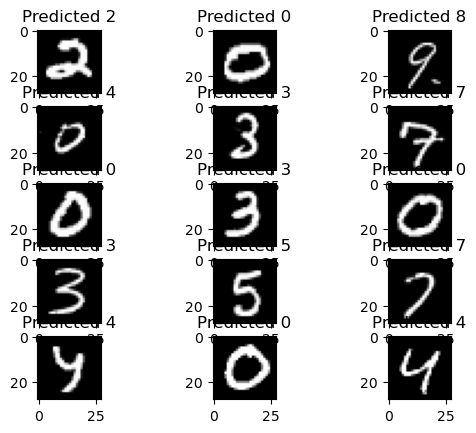

In [70]:
plt.figure()
f, xarr = plt.subplots(5,3)
counter = 0
for i in range(5):
    for j in range(3):
        xarr[i][j].imshow(imgs[counter].squeeze(),cmap="gray")
        xarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter +=1

plt.show()